## Семинар 8: "Снижение размерности"

ФИО: Каспарьянц Георгий Григорьевич

In [9]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [3]:
X = fetch_olivetti_faces()['data']

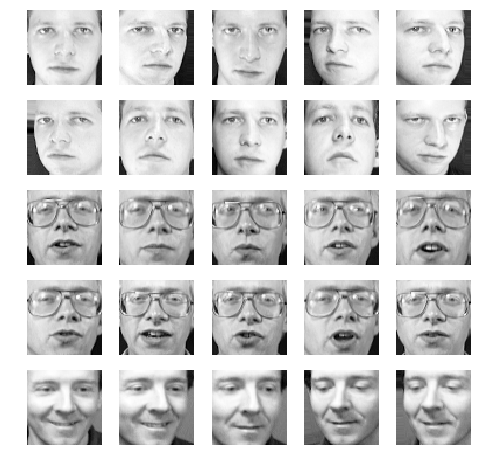

In [4]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [7]:
pca = PCA(n_components=25)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

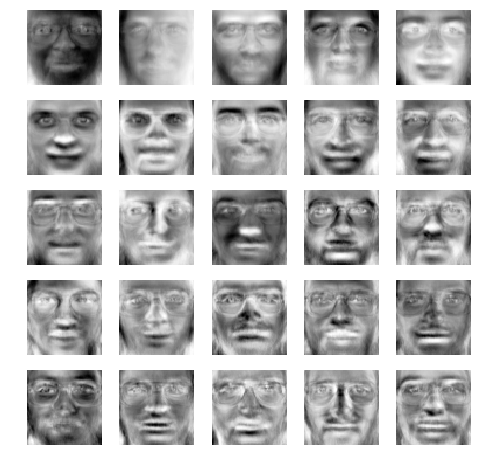

In [12]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(pca.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

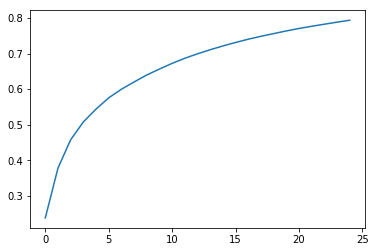

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

По методу локтя 5 компонент

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?</i>

In [100]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in xrange(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

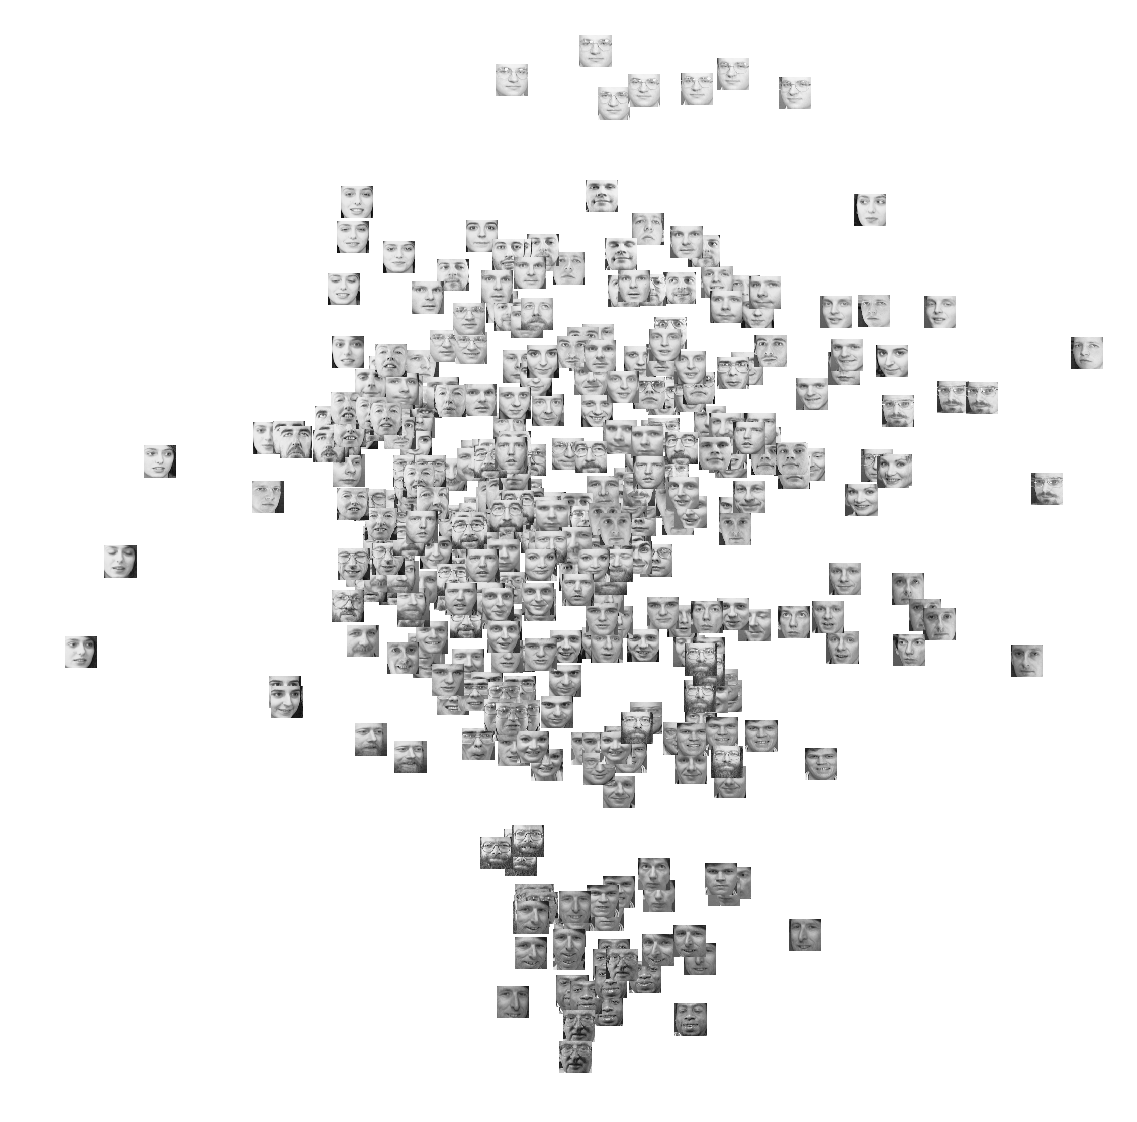

In [23]:
pca = PCA(n_components=2)
data2d = pca.fit_transform(X)
plot_dataset(X, data2d)

Кажется, что 2 кластера, молодые и старые лица

###  Часть 2: Автокодировщик

In [50]:
class FacesData(Dataset):
    def __init__(self, X):
        super(FacesData, self).__init__()
        self.data = np.array(X)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 50
ds = FacesData(X)
loader = DataLoader(ds, shuffle=True, batch_size=batch_size)
epoch = 100

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [55]:
encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, 10), nn.Sigmoid())
decoder = nn.Sequential(nn.Linear(10, 200), nn.Linear(200, 4096))
loss_fn = nn.MSELoss()
params = list(encoder.parameters()) + list(decoder.parameters())
opt = torch.optim.Adam(params=params)
losses = []
for ep in tqdm(range(epoch)):
    for batch in loader:
        x = Variable(torch.FloatTensor(batch))
        y = Variable(torch.FloatTensor(batch), requires_grad = False)
        x = encoder(x)
        y_pred = decoder(x)
    
        loss = loss_fn(y_pred, y)
        losses.append(loss.data.numpy()[0])
        
        opt.zero_grad()
        loss.backward()
        opt.step()

100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


<i> 2.2 Какое качество восстановления удалось получить?</i>

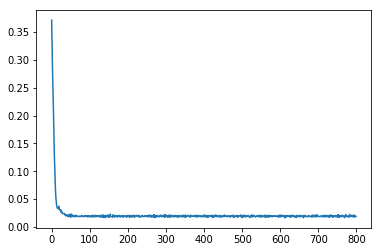

In [56]:
opt = torch.optim.Adam(params=model.parameters(), lr=0.5)

plt.plot(losses)
plt.show()

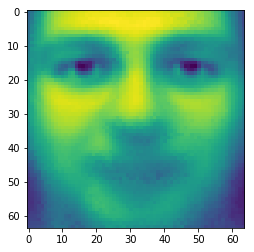

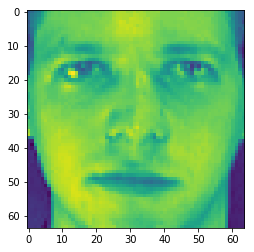

In [58]:
x = encoder(Variable(torch.FloatTensor(ds[0])).view(1,-1))
pic = decoder(x)
plt.imshow(pic.data.numpy().reshape(64, 64))
plt.show()
plt.imshow(ds[0].reshape(64, 64))
plt.show()

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [109]:
graph=[]
encoders = []
decoders = []
epoch = 15
for i in tqdm(range(2, 26)):
    encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, i), nn.Sigmoid())
    decoder = nn.Sequential(nn.Linear(i, 200), nn.Linear(200, 4096))
    loss_fn = nn.MSELoss()
    params = list(encoder.parameters()) + list(decoder.parameters())
    opt = torch.optim.Adam(params=params)
    losses = []
    for ep in range(epoch):
        for batch in loader:
            x = Variable(torch.FloatTensor(batch))
            y = Variable(torch.FloatTensor(batch), requires_grad = False)
            x = encoder(x)
            y_pred = decoder(x)

            loss = loss_fn(y_pred, y)
            losses.append(loss.data.numpy()[0])

            opt.zero_grad()
            loss.backward()
            opt.step()
    graph.append((i, losses[-1]))
    encoders.append(encoder)
    decoders.append(decoder)

100%|██████████| 24/24 [05:37<00:00, 14.05s/it]


<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

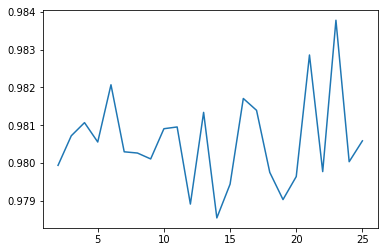

In [110]:
graph = np.array(graph)
plt.plot(graph[:, 0], 1-graph[:,1])

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

(400, 2)


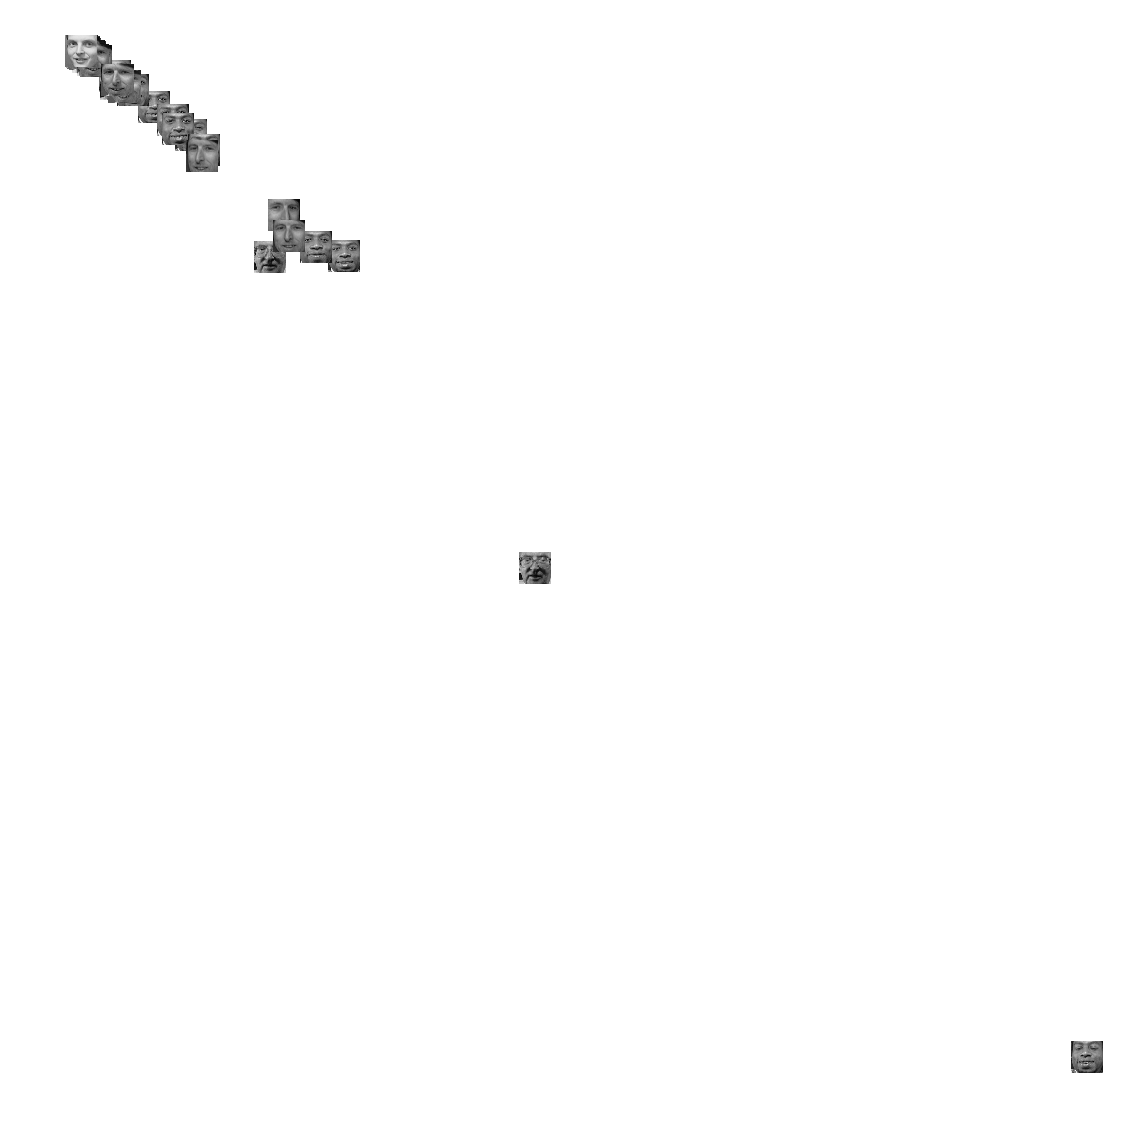

In [111]:
x = Variable(torch.FloatTensor(X))
data2d = encoders[0](x).data.numpy()
print(data2d.shape)
plot_dataset(X, data2d)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: